# Subgrid Emulator - Basic Usage Examples

This notebook demonstrates how to use the `subgrid_emu` package to make predictions for various cosmological summary statistics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subgrid_emu import (
    load_emulator, 
    list_available_statistics,
    get_x_grid,
    get_plot_info,
    get_parameter_info
)

# Set plotting style
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
%matplotlib inline

## 1. List Available Statistics

In [2]:
stats = list_available_statistics()
print("5-parameter models:")
for stat in stats['5-parameter']:
    print(f"  - {stat}")
    
print("\n2-parameter models:")
for stat in stats['2-parameter']:
    print(f"  - {stat}")

5-parameter models:
  - GSMF
  - fGas
  - CGD
  - BHMSM
  - Pk
  - CSFR

2-parameter models:
  - fGas_2p
  - CGD_2p


## 2. Parameter Information

In [3]:
param_info = get_parameter_info()

print("Input Parameters:")
print("=" * 80)
for i, name in enumerate(param_info['names']):
    latex_name = param_info['latex_names'][i]
    range_val = param_info['ranges'][name]
    desc = param_info['descriptions'][name]
    print(f"{i+1}. {name} ({latex_name})")
    print(f"   Range: {range_val}")
    print(f"   Description: {desc}")
    print()

Input Parameters:
1. kappa_w ($\kappa_\text{w}$)
   Range: (2.0, 4.0)
   Description: Wind efficiency parameter

2. e_w ($e_\text{w}$)
   Range: (0.2, 1.0)
   Description: Wind energy fraction

3. M_seed ($M_\text{seed}/10^{6}$)
   Range: (0.6, 1.2)
   Description: Black hole seed mass (in 10^6 M_sun)

4. v_kin ($v_\text{kin}/10^{4}$)
   Range: (0.1, 1.2)
   Description: Kinetic wind velocity (in 10^4 km/s)

5. epsilon_kin ($\epsilon_\text{kin}/10^{1}$)
   Range: (0.02, 1.2)
   Description: Kinetic feedback efficiency (in 10^1)



## 3. All 5-Parameter Models

Display predictions for all available 5-parameter summary statistics.

In [4]:
list_available_statistics()['5-parameter']

['GSMF', 'fGas', 'CGD', 'BHMSM', 'Pk', 'CSFR']

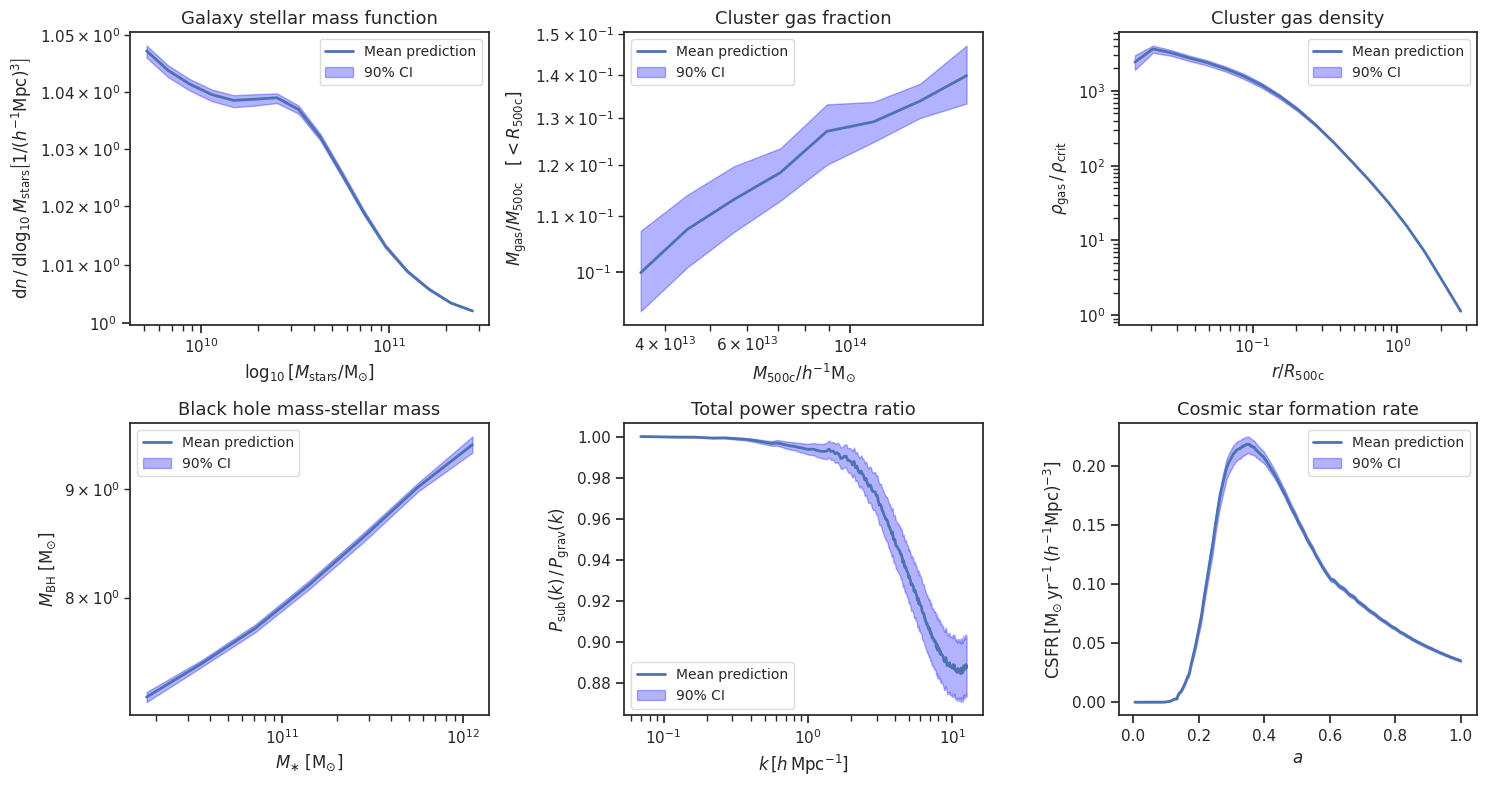


Showing predictions for 6 summary statistics with 5 parameters
Parameters used: [3.  0.5 0.8 0.5 0.1]


In [5]:
# Define parameters: [kappa_w, e_w, M_seed/1e6, v_kin/1e4, eps/1e1]
params_5p = np.array([3.0, 0.5, 0.8, 0.5, 0.1])

# Get all 5-parameter statistics
stats_5p = list_available_statistics()['5-parameter']
# stats_5p = ['GSMF', 'BHMSM', 'fGas', 'CGD', 'CSFR'] # works without Pk

# Create subplots
n_stats = len(stats_5p)
n_cols = 3
n_rows = (n_stats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_stats > 1 else [axes]

for i, stat_name in enumerate(stats_5p):
    # Load emulator
    emu = load_emulator(stat_name)
    
    # Make prediction
    mean, quantiles = emu.predict(params_5p)
    
    # Get plotting info
    x_grid, _ = get_x_grid(stat_name)
    plot_info = get_plot_info(stat_name)
    
    # Plot
    ax = axes[i]
    ax.plot(x_grid, mean, 'b-', lw=2, label='Mean prediction')
    ax.fill_between(x_grid, quantiles[:, 0], quantiles[:, 1], 
                    alpha=0.3, color='blue', label='90% CI')
    ax.set_xscale(plot_info['xscale'])
    ax.set_yscale(plot_info['yscale'])
    ax.set_xlabel(plot_info['xlabel'], fontsize=12)
    ax.set_ylabel(plot_info['ylabel'], fontsize=12)
    ax.set_title(plot_info['title'], fontsize=13)
    ax.legend(fontsize=10, frameon=True, framealpha=0.7)
    # ax.grid(True, alpha=0.3)

# Hide extra subplots
for i in range(n_stats, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\nShowing predictions for {n_stats} summary statistics with 5 parameters")
print(f"Parameters used: {params_5p}")

## 4. All 2-Parameter Models

Display predictions for all available 2-parameter summary statistics.

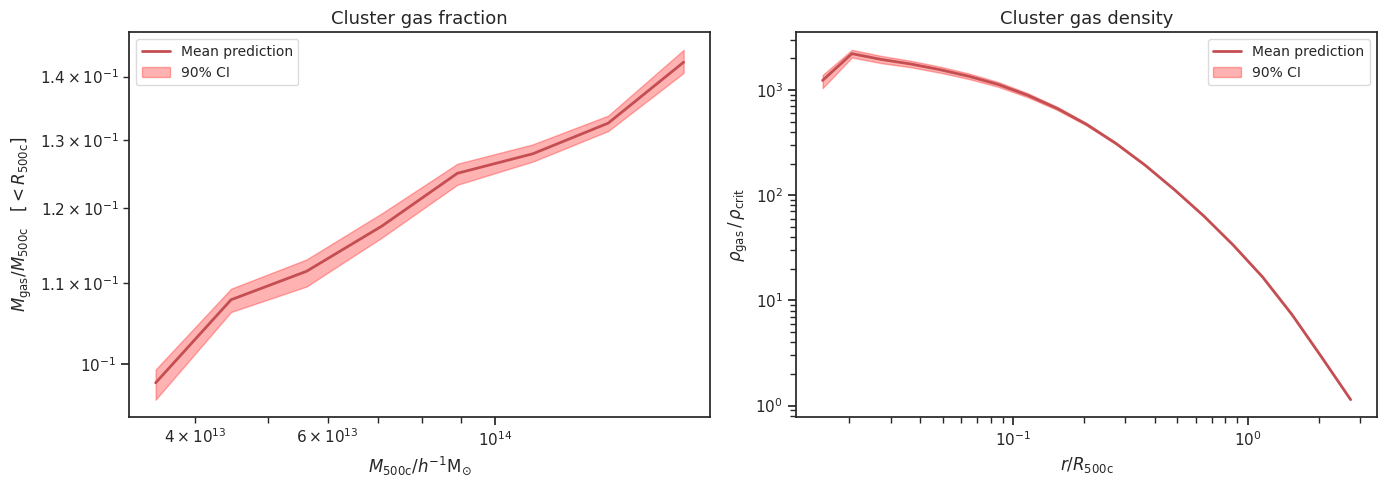


Showing predictions for 2 summary statistics with 2 parameters
Parameters used: [0.5 0.1]


In [6]:
# Define 2-parameter inputs: [v_kin/1e4, eps/1e1]
params_2p = np.array([0.5, 0.1])

# Get all 2-parameter statistics
stats_2p = list_available_statistics()['2-parameter']

# Create subplots
n_stats = len(stats_2p)
fig, axes = plt.subplots(1, n_stats, figsize=(7*n_stats, 5))
if n_stats == 1:
    axes = [axes]

for i, stat_name in enumerate(stats_2p):
    # Load emulator
    emu = load_emulator(stat_name)
    
    # Make prediction
    mean, quantiles = emu.predict(params_2p)
    
    # Get plotting info
    x_grid, _ = get_x_grid(stat_name)
    plot_info = get_plot_info(stat_name)
    
    # Plot
    ax = axes[i]
    ax.plot(x_grid, mean, 'r-', lw=2, label='Mean prediction')
    ax.fill_between(x_grid, quantiles[:, 0], quantiles[:, 1], 
                    alpha=0.3, color='red', label='90% CI')
    ax.set_xscale(plot_info['xscale'])
    ax.set_yscale(plot_info['yscale'])
    ax.set_xlabel(plot_info['xlabel'], fontsize=12)
    ax.set_ylabel(plot_info['ylabel'], fontsize=12)
    ax.set_title(plot_info['title'], fontsize=13)
    ax.legend(fontsize=10, frameon=True, framealpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nShowing predictions for {n_stats} summary statistics with 2 parameters")
print(f"Parameters used: {params_2p}")

## 5. Parameter Variation Study

Study how predictions change with varying kinetic feedback efficiency.

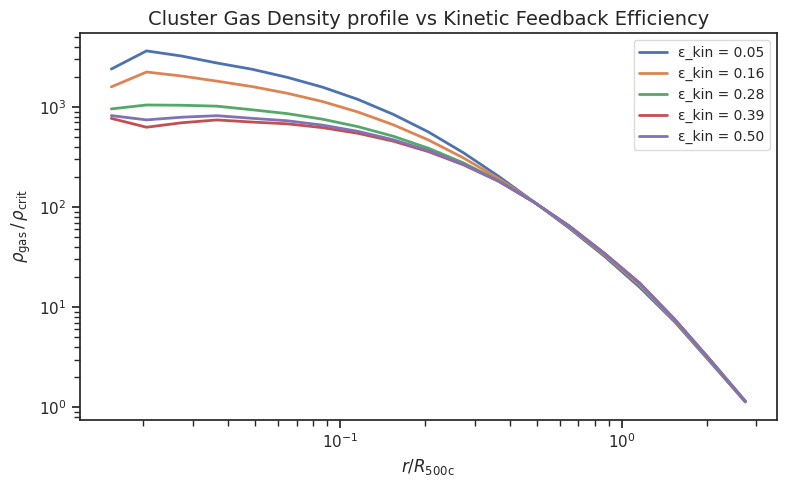

In [9]:
# Load emulator for gas density profile
emu_cgd = load_emulator('CGD')

# Base parameters
base_params = np.array([3.0, 0.5, 0.8, 0.65, 0.1])

# Vary the last parameter (epsilon_kin)
eps_values = np.linspace(0.05, 0.5, 5)

# Get x-grid
x_grid, _ = get_x_grid('CGD')
plot_info = get_plot_info('CGD')

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

for eps in eps_values:
    params = base_params.copy()
    params[4] = eps
    
    mean, _ = emu_cgd.predict(params)
    
    ax.plot(x_grid, mean, lw=2, label=f'ε_kin = {eps:.2f}')

ax.set_xscale(plot_info['xscale'])
ax.set_yscale(plot_info['yscale'])
ax.set_xlabel(plot_info['xlabel'], fontsize=12)
ax.set_ylabel(plot_info['ylabel'], fontsize=12)
ax.set_title('Cluster Gas Density profile vs Kinetic Feedback Efficiency', fontsize=14)
ax.legend(fontsize=10, frameon=True, framealpha=0.7)
plt.tight_layout()
plt.show()

## 6. Batch Predictions

Make predictions for multiple parameter sets simultaneously.

Parameter samples:
[[2.74908024 0.96057145 1.03919637 0.75852433 0.09488895]
 [2.31198904 0.24646689 1.11970569 0.76122651 0.35987484]
 [2.04116899 0.97592788 1.09946558 0.33357302 0.10727598]
 [2.36680902 0.44339379 0.91485386 0.57513952 0.15978999]
 [3.22370579 0.31159509 0.77528679 0.50299803 0.23891359]]



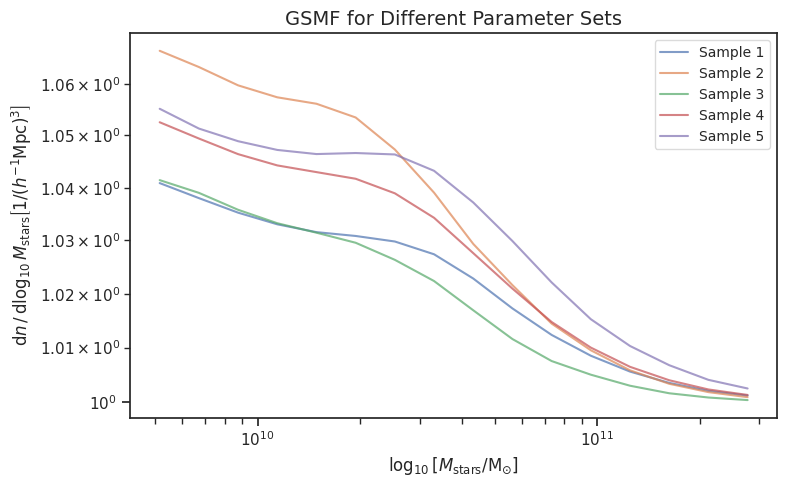

In [8]:
# Load emulator
emu = load_emulator('GSMF')

# Create random parameter samples
np.random.seed(42)
n_samples = 5
params_batch = np.random.uniform(
    low=[2.0, 0.2, 0.6, 0.1, 0.02],
    high=[4.0, 1.0, 1.2, 1.2, 0.5],
    size=(n_samples, 5)
)

print("Parameter samples:")
print(params_batch)
print()

# Make predictions
x_grid, _ = get_x_grid('GSMF')
plot_info = get_plot_info('GSMF')

fig, ax = plt.subplots(figsize=(8, 5))

for i, params in enumerate(params_batch):
    mean, _ = emu.predict(params)
    ax.plot(x_grid, mean, lw=1.5, alpha=0.7, label=f'Sample {i+1}')

ax.set_xscale(plot_info['xscale'])
ax.set_yscale(plot_info['yscale'])
ax.set_xlabel(plot_info['xlabel'], fontsize=12)
ax.set_ylabel(plot_info['ylabel'], fontsize=12)
ax.set_title('GSMF for Different Parameter Sets', fontsize=14)
ax.legend(fontsize=10, frameon=True, framealpha=0.7)
plt.tight_layout()
plt.show()